In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [7]:
# Define your dataset path
data_dir = "processed_images"
batch_size = 32
img_size = (224, 224)  # Standard input size for EfficientNet

# Load dataset first
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# ✅ Extract class names BEFORE prefetching
class_names = train_ds.class_names

# THEN apply prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [8]:

# Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


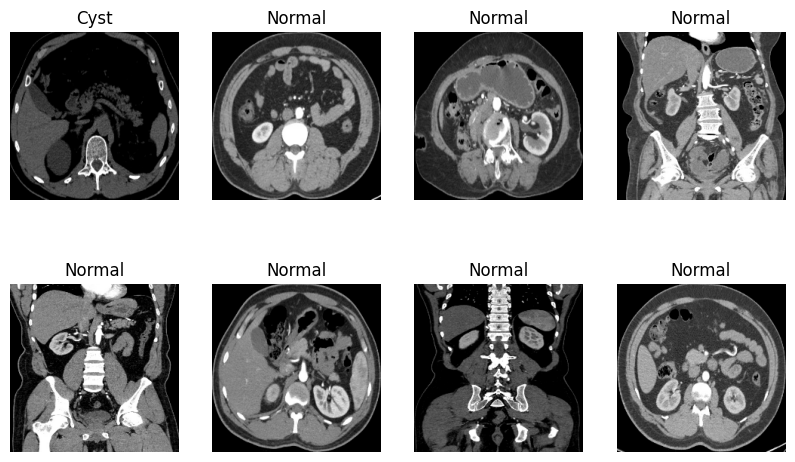

In [9]:

plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [10]:
# Load pretrained base model
base_model = EfficientNetB0(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom classification head
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step


In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.6434 - loss: 0.9168 - val_accuracy: 0.8072 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.8221 - loss: 0.4979 - val_accuracy: 0.8602 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.8646 - loss: 0.4088 - val_accuracy: 0.8670 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.8720 - loss: 0.3706 - val_accuracy: 0.8819 - val_loss: 0.3551 - learning_rate: 0.0010
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.8784 - loss: 0.3453 - val_accuracy: 0.8819 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8857 - loss: 0.3307 - val_accuracy: 0.8771 - val_loss: 0.3282 - learning_rate: 0.0010
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8954 - loss: 0.

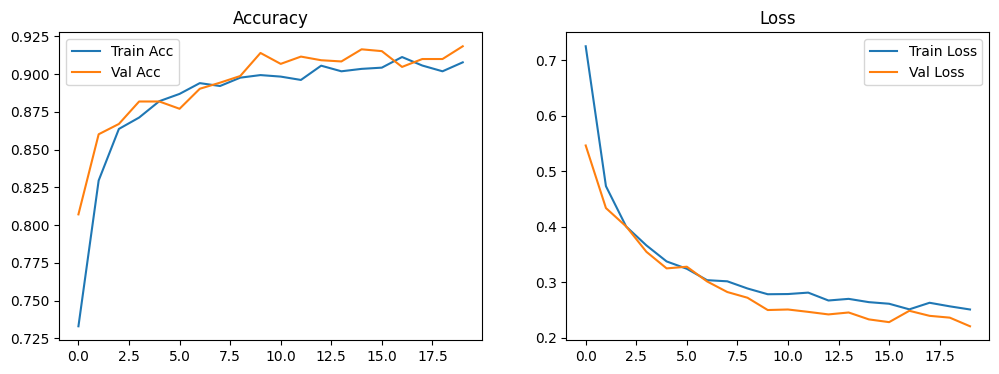

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


78/78 ━━━━━━━━━━━━━━━━━━━━ 73s 935ms/step - accuracy: 0.9168 - loss: 0.2297
Validation Accuracy: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

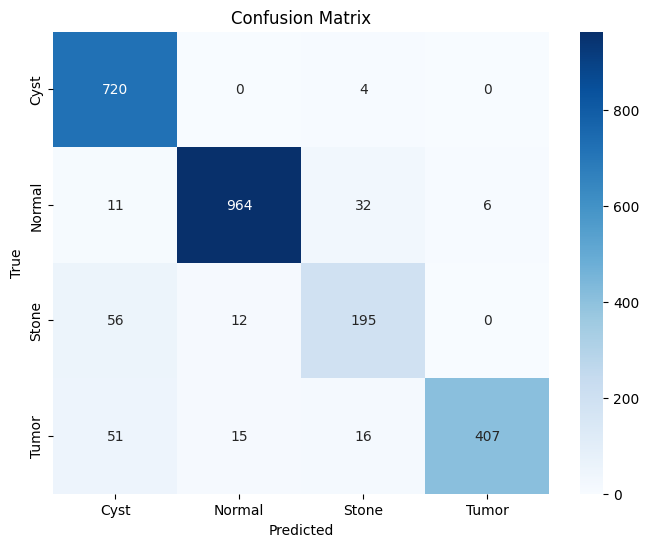

In [13]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
def predict_new_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_label = class_names[np.argmax(score)]

    print(f"Predicted: {predicted_label} ({100 * np.max(score):.2f}%)")

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted: Normal (46.15%)


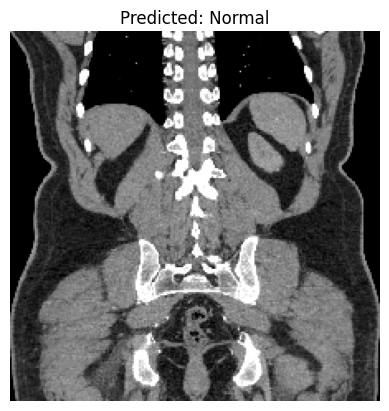

In [25]:
predict_new_image("processed_images/Normal/Normal- (226).jpg")